# Import Necessary Files 


In [0]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from keras.utils import plot_model

import pickle
from tqdm import tqdm
import string

import pandas as pd
import seaborn as sns

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Creating VGG16 Model for Extract Image Features

553467904/553467096 [==============================] - 42s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
___________________________________________________________

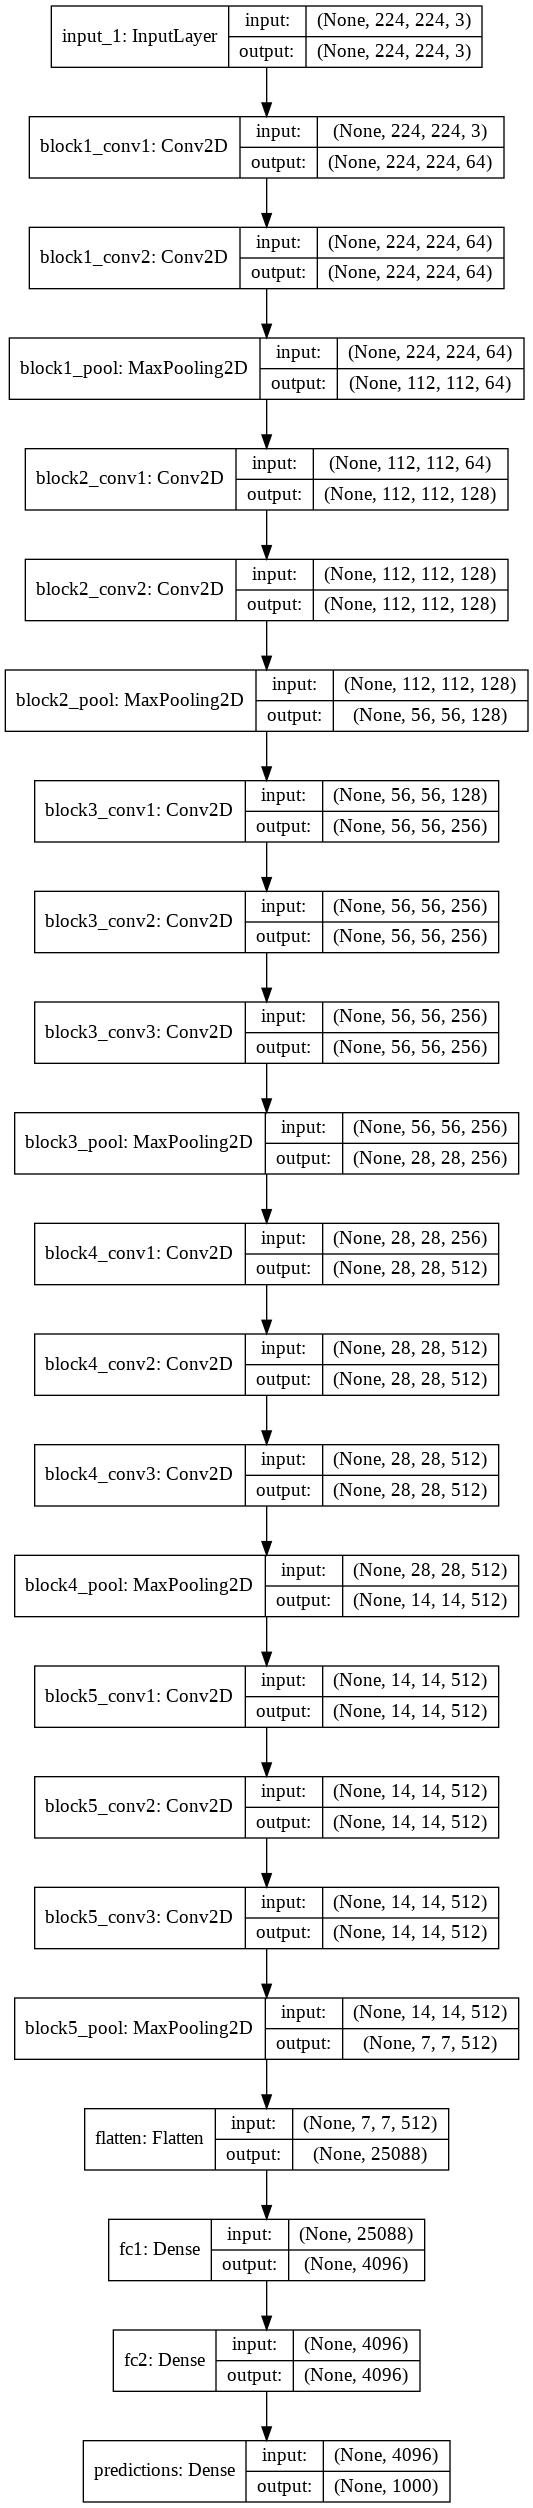

In [0]:
# Orginal VGG16 Model
vgg16 = VGG16()
vgg16.summary()
plot_model(vgg16, to_file='vgg16_model.png', show_shapes=True, show_layer_names=True)

In [0]:
def get_image_feature_extractor_model(): 
    vgg16 = VGG16()
    image_feature_extractor_model = Model(inputs=vgg16.inputs, outputs=vgg16.get_layer('fc2').output) # Prepare VGG16 for Transfer learning
    return image_feature_extractor_model   

In [0]:
image_fe_model=get_image_feature_extractor_model()
image_fe_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

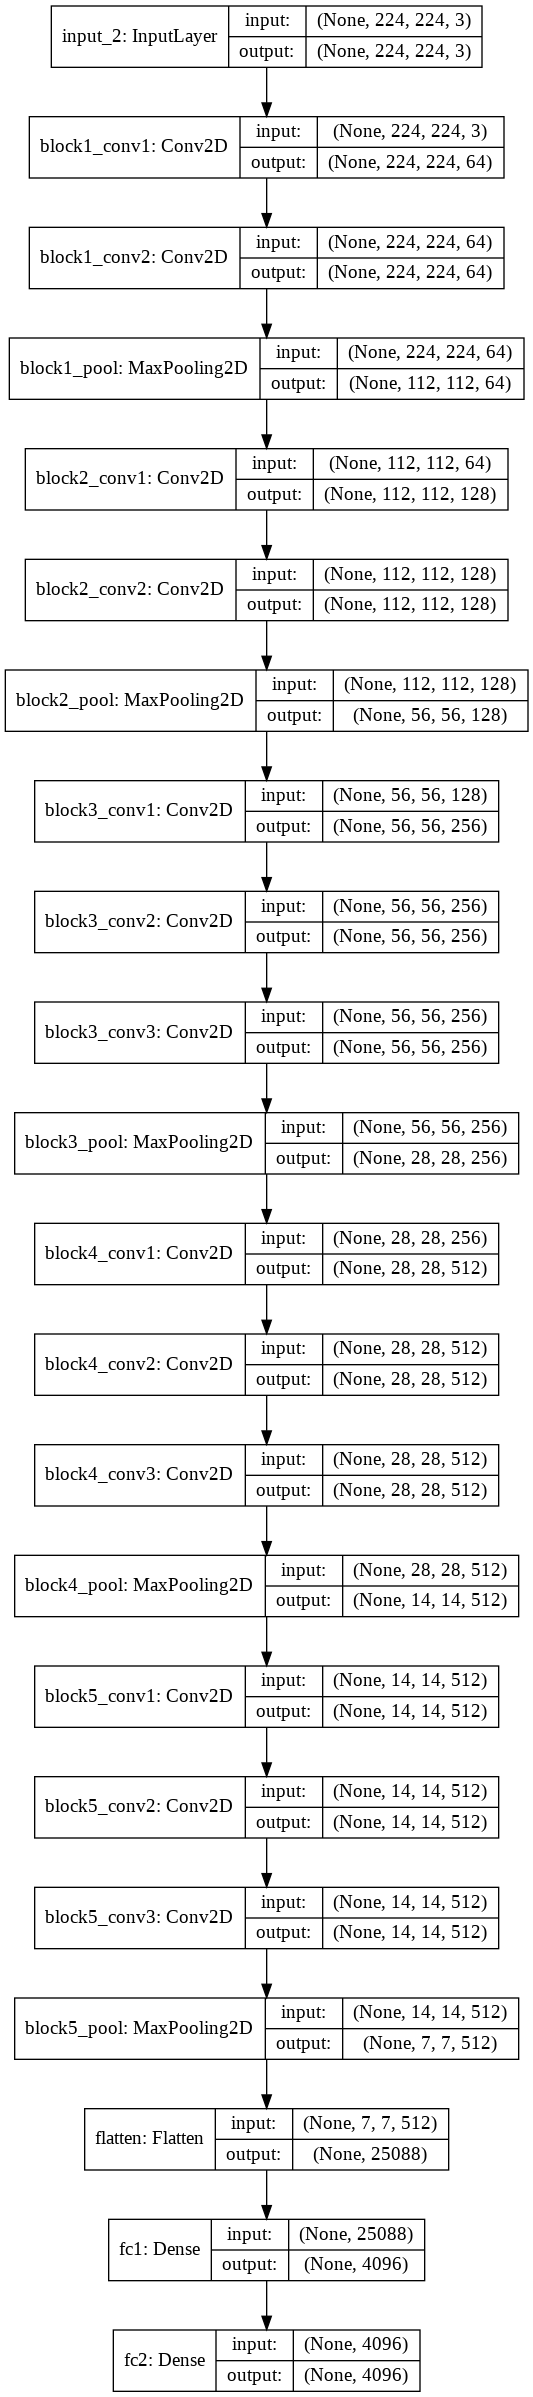

In [0]:
plot_model(image_fe_model, to_file='image_feature_extractor_model.png', show_shapes=True, show_layer_names=True) # Showing Model Description visually

# Extract Features From Each Image

In [0]:
def extract_image_features(directory,image_fe_model):
    features = []
    for name in tqdm(listdir(directory)):
        filename = directory + '/' + name
        image = load_img(filename, target_size=(224, 224))
        image = img_to_array(image)
        x,y,z=image.shape
        image = image.reshape((1, x, y, z))
        image = preprocess_input(image)
        feature = image_fe_model.predict(image, verbose=0)
        image_id = name.split('.')[0] #get image id without format
        features.append([image_id,feature])
    return features

directory = '/kaggle/input/flicker8k-dataset/Flickr8k_Dataset/Flicker8k_Dataset'
features = extract_image_features(directory,image_fe_model)

In [0]:
import pandas as pd
df=pd.DataFrame(features, columns=['Image Id','Image Feature'])
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8091 entries, 0 to 8090
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Image Id       8091 non-null   object
 1   Image Feature  8091 non-null   object
dtypes: object(2)
memory usage: 126.5+ KB


,Image Id,Image Feature
0,3301935788_2bb7bbc515,"[[2.0854492, 0.0, 3.8270073, 0.5696756, 4.3478..."
1,3608400551_d6f7965308,"[[1.7588447, 3.8115203, 1.1859796, 0.0, 0.4590..."
2,2056377805_e9a9b3bcf0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.568263..."
3,3275704430_a75828048f,"[[0.0, 2.8174336, 0.20962474, 0.0, 1.8711638, ..."
4,72964268_d532bb8ec7,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0440122..."


# Load Captions

In [0]:
def load_caption(filename):
    with open(filename,'r') as fp:
        text=fp.read()
    mapping = {}
    for line in tqdm(text.split('\n')):
        tokens = line.split()
        if len(line) < 2: # There can be missing caption or blank line
            continue
        image_id, image_caption = tokens[0], tokens[1:] # first token -> image id, from 2nd one-> Caption
        image_id = image_id.split('.')[0]
        image_caption = ' '.join(image_caption) # converting all the caption token to sentense
        if image_id not in mapping:
            mapping[image_id] = [list()] # Creating a list againest each image as there can be multiple caption for single image
        mapping[image_id][0].append(image_caption)
    return mapping
file_dir='/kaggle/input/flicker8k-dataset/Flickr8k_text/Flickr8k.token.txt'
captions = load_caption(file_dir)

In [0]:
df['Caption']=df['Image Id'].copy()
df['Caption']=df['Caption'].map(captions)
df.head()

,Image Id,Image Feature,Caption
0,3301935788_2bb7bbc515,"[[2.0854492, 0.0, 3.8270073, 0.5696756, 4.3478...",[[person in white coat and pink pants snowboar...
1,3608400551_d6f7965308,"[[1.7588447, 3.8115203, 1.1859796, 0.0, 0.4590...","[[man is playing fetch with dog, man with tato..."
2,2056377805_e9a9b3bcf0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.568263...","[[group of friends ride the current in raft, g..."
3,3275704430_a75828048f,"[[0.0, 2.8174336, 0.20962474, 0.0, 1.8711638, ...",[[person in black covering their face with the...
4,72964268_d532bb8ec7,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0440122...",[[man in wetsuit with surfboard walks along be...


Now we have all the data in df Dataframe

# Preprocessing Caption

In [0]:
def preprocess_caption(image_captions):
    updated_captions=[]
    for caption in image_captions[0]: #we used image_captions[0] instead of image_captions to unwraping the outer []
        no_punctuation = [char for char in caption if char not in string.punctuation]
        no_punctuation = ''.join(no_punctuation)
        tokens = no_punctuation.split()
        tokens = [word.lower() for word in tokens]
        tokens = [word for word in tokens if len(word)>1] # remove single 's' and 'a' (may occur after removing punc)
        tokens = [word for word in tokens if word.isalpha()] # remove numeric value
        processed_caption = ' '.join(tokens) # processed caption
        updated_captions.append('startseq '+processed_caption+' endseq ')
    return [updated_captions]   

In [0]:
df['Caption']=df['Caption'].apply(lambda img_captions:preprocess_caption(img_captions))

In [0]:
df

,Image Id,Image Feature,Caption
0,3301935788_2bb7bbc515,"[[2.0854492, 0.0, 3.8270073, 0.5696756, 4.3478...",[[startseq person in white coat and pink pants...
1,3608400551_d6f7965308,"[[1.7588447, 3.8115203, 1.1859796, 0.0, 0.4590...",[[startseq man is playing fetch with dog endse...
2,2056377805_e9a9b3bcf0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.568263...",[[startseq group of friends ride the current i...
3,3275704430_a75828048f,"[[0.0, 2.8174336, 0.20962474, 0.0, 1.8711638, ...",[[startseq person in black covering their face...
4,72964268_d532bb8ec7,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0440122...",[[startseq man in wetsuit with surfboard walks...
...,...,...,...
8086,3149919755_f9272b10b3,"[[1.6306396, 0.0, 0.4254883, 0.0, 2.1839051, 0...",[[startseq black dog is looking at the ball on...
8087,2125626631_a4b63af97e,"[[0.0, 0.0, 3.4685364, 0.0, 0.0, 0.0, 1.434970...","[[startseq dog catching frisbee endseq , start..."
8088,2660008870_b672a4c76a,"[[0.0, 0.0, 0.18132839, 0.0, 3.6582055, 0.0, 1...",[[startseq boy is making splash in swimming po...
8089,3528902357_be2357a906,"[[0.0, 0.2781116, 0.0, 0.0, 0.51448435, 0.0, 0...",[[startseq bicyclist is attempting trick while...


Image Id         0
Image Feature    0
Caption          0
dtype: int64


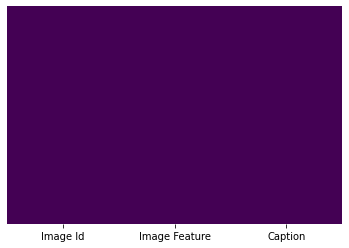

In [0]:
# Check if there are any missing value
print(df.isnull().sum(axis=0))
sns.heatmap(df.isnull(),yticklabels=False,cbar=False,cmap='viridis')

No Missing Value. We Are Good to Go

In [0]:
# Save the data
pickle.dump(df,open('flicker8k.pkl','wb'))

# Separately Load Train Test Dev Data From Predefined Text File 

In [0]:
df=pickle.load(open('flicker8k.pkl','rb')) # Loding the data we saved  

In [0]:
def get_data(file,df):
    with open(file,'r') as fp:
        doc=fp.read()
    data = []
    for line in doc.split('\n'):
        if len(line) < 1:
            continue
        id = line.split('.')[0]
        data.append(id)
    data=set(data)
    return df[df['Image Id'].isin(data)]    

In [0]:
# Load Training Data
filename = '/kaggle/input/flicker8k-dataset/Flickr8k_text/Flickr_8k.trainImages.txt'
train = get_data(filename,df)
train

,Image Id,Image Feature,Caption
0,3301935788_2bb7bbc515,"[[2.0854492, 0.0, 3.8270073, 0.5696756, 4.3478...",[[startseq person in white coat and pink pants...
1,3608400551_d6f7965308,"[[1.7588447, 3.8115203, 1.1859796, 0.0, 0.4590...",[[startseq man is playing fetch with dog endse...
2,2056377805_e9a9b3bcf0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.568263...",[[startseq group of friends ride the current i...
4,72964268_d532bb8ec7,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0440122...",[[startseq man in wetsuit with surfboard walks...
5,2663248626_f000f2661d,"[[0.60427487, 5.1025906, 0.11184016, 0.0, 0.56...",[[startseq black and white dog chasing tan and...
...,...,...,...
8084,2622517932_57c52c376f,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.05...",[[startseq boy in white shirt is looking throu...
8085,129599450_cab4e77343,"[[0.0, 1.2539675, 0.0, 0.0, 2.7728987, 0.0, 0....",[[startseq backpacker in the mountains wearing...
8087,2125626631_a4b63af97e,"[[0.0, 0.0, 3.4685364, 0.0, 0.0, 0.0, 1.434970...","[[startseq dog catching frisbee endseq , start..."
8089,3528902357_be2357a906,"[[0.0, 0.2781116, 0.0, 0.0, 0.51448435, 0.0, 0...",[[startseq bicyclist is attempting trick while...


In [0]:
# Load Dev Data
filename = '/kaggle/input/flicker8k-dataset/Flickr8k_text/Flickr_8k.testImages.txt'
dev = get_data(filename,df)
dev

,Image Id,Image Feature,Caption
3,3275704430_a75828048f,"[[0.0, 2.8174336, 0.20962474, 0.0, 1.8711638, ...",[[startseq person in black covering their face...
9,533483374_86c5d4c13e,"[[0.0, 2.667647, 0.6864884, 0.0, 0.6457726, 0....",[[startseq brown and white dog is standing on ...
17,700884207_d3ec546494,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",[[startseq baby is dressed up in pink gear and...
40,2393264648_a280744f97,"[[0.0, 0.0, 0.0, 0.0, 3.1548662, 0.0, 0.0, 2.0...",[[startseq child on the beach while woman take...
46,311146855_0b65fdb169,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.9450743...",[[startseq man and woman in festive costumes d...
...,...,...,...
8060,1096395242_fc69f0ae5a,"[[0.0, 0.0, 0.0, 0.0, 0.09855011, 0.0, 0.0, 2....","[[startseq boy with toy gun endseq , startseq ..."
8067,544576742_283b65fa0d,"[[0.4099903, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0...",[[startseq rock climber repels off rocky wall ...
8079,263854883_0f320c1562,"[[0.0, 1.1676048, 1.1720791, 3.79256, 0.0, 0.0...",[[startseq the two small dogs run through the ...
8086,3149919755_f9272b10b3,"[[1.6306396, 0.0, 0.4254883, 0.0, 2.1839051, 0...",[[startseq black dog is looking at the ball on...


In [0]:
# Load Test Data
filename = '/kaggle/input/flicker8k-dataset/Flickr8k_text/Flickr_8k.devImages.txt'
test = get_data(filename,df)
test

,Image Id,Image Feature,Caption
26,465994762_1760e83c5d,"[[2.2926521, 0.0, 0.0, 4.448601, 0.0, 0.0, 0.0...","[[startseq brown dog jumps over chain endseq ,..."
32,2874876837_80d178ba9b,"[[0.0, 7.4729495, 0.7283358, 0.0, 0.0, 0.0, 0....","[[startseq boy bouncing on trampoline endseq ,..."
51,3365602213_dd3287a633,"[[0.0, 0.03887734, 2.0754976, 0.0, 0.0, 0.0, 0...",[[startseq kid is climbing on rope course ends...
61,2939371251_f923569a72,"[[0.0, 0.6389697, 0.0, 0.0, 0.0, 0.0, 0.0, 7.5...",[[startseq football player runs with the ball ...
92,3720210639_18bb34e475,"[[1.064797, 0.58866817, 0.0, 0.70010865, 1.345...",[[startseq person in red hat and shoes doing s...
...,...,...,...
8054,1177994172_10d143cb8d,"[[0.9156531, 2.836488, 0.0, 0.0, 0.0, 0.0, 0.0...",[[startseq two blonde boys one in camouflage s...
8057,3240351042_5d29c94b0e,"[[0.23039487, 1.8796304, 0.0, 0.0, 4.291272, 0...",[[startseq biker rider jumping high over dirt ...
8061,2429212017_77fc107699,"[[0.0, 2.1046658, 2.1990266, 0.0, 1.6308056, 0...",[[startseq the children in the scene are in pe...
8064,2185793891_5a5e903ca6,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.2951636...","[[startseq baby cries in woman arms endseq , s..."


# Defining Some Helper Function

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np


# Covert caption column to a list of captions
def to_lines(captions):
    all_caption = []
    for caption in captions:
        [all_caption.append(data) for data in caption[0]] # Again, we used caption[0] instead of caption to unwrap outer []
    return all_caption


# Fit a tokenizer to the given captions
def create_tokenizer(captions):
    lines = to_lines(captions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer


# Calculate the length of the caption with most words
def max_length(captions):
    lines = to_lines(captions)
    max_len=max(len(d.split()) for d in lines)
    return max_len


# Create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, caption_list, image, vocab_size):
    X1, X2, y = [], [], []
    
    for caption in caption_list:
        seq = tokenizer.texts_to_sequences([caption])[0]
        for i in range(1, len(seq)):
            input_seq, output_seq = seq[:i], seq[i]
            input_seq = pad_sequences([input_seq], maxlen=max_length)[0]
            output_seq = to_categorical([output_seq], num_classes=vocab_size)[0]
            X1.append(image)
            X2.append(input_seq)
            y.append(output_seq)
    return np.array(X1), np.array(X2), np.array(y)

# Below code is used to progressively load the batch of data
# Data generator will be called from model.fit_generator()
# We need to use this method rather fit to work with limited resource like RAM
def data_generator(train_data, tokenizer, max_length,vocab_size):
    # Loop for ever over images
    while 1:
        for image_id,image_feature,image_captions in train_data:
            image = image_feature[0]  # get image feature by unwraping outer []
            caption_list=image_captions[0] # get all the captions of an image by unwraping outer []
            input_img, input_seq, output_word = create_sequences(tokenizer, max_length, caption_list, image,vocab_size)
            yield [[input_img, input_seq], output_word]

# Building Model and Train

In [0]:
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.callbacks import ModelCheckpoint

def build_model(vocab_size, max_length):
    # feature extractor model for image part
    inputs1 = Input(shape=(4096,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu',kernel_initializer='he_uniform')(fe1)
    # sequence model for caption
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # Mergeing Image and Sequence
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu',kernel_initializer='he_uniform')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # Image+caption X->[image, seq]   y->[word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    return model

In [0]:
print('Train Data ' ,len(train))
tokenizer = create_tokenizer(train['Caption'])
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: ' , vocab_size)
max_len = max_length(train['Caption'])
print('Max Length: ' , max_len)

Train Data  6000
Vocabulary Size:  7579
Max Length:  34


In [0]:
model = build_model(vocab_size, max_len)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 34)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      1940224     input_4[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_3[0][0]                    
____________________________________________________________________________________________

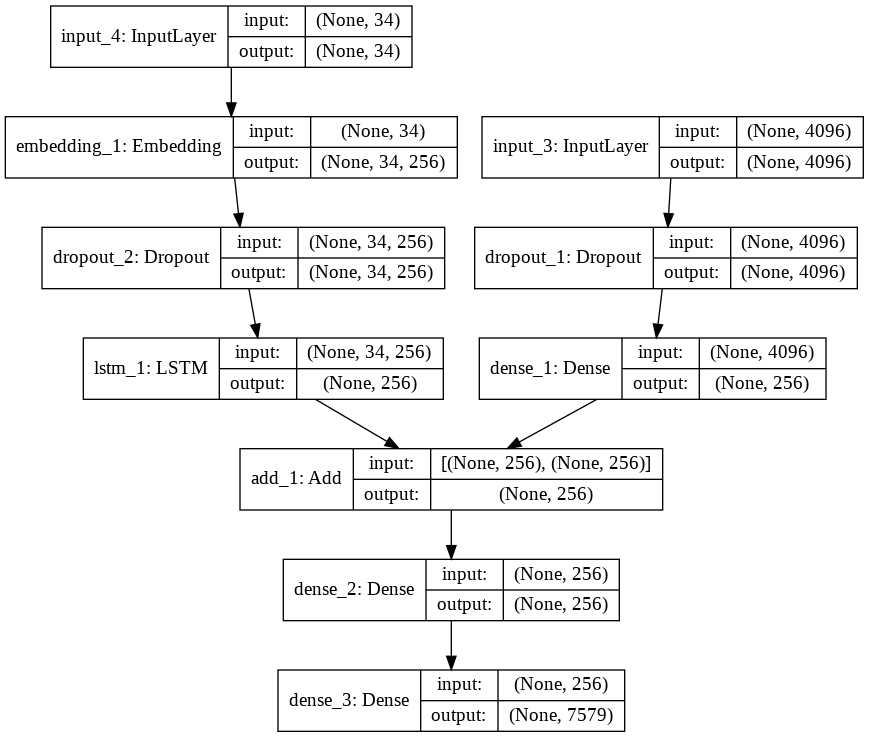

In [0]:
plot_model(model, to_file='image_captioning_model.png', show_shapes=True, show_layer_names=True) # Showing Model Description Visually

In [0]:
from keras.callbacks import ModelCheckpoint
# define checkpoint callback
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [0]:
import tensorflow as tf
num_epoch= 25
train_generator = data_generator(train.values, tokenizer, max_len,vocab_size)
dev_generator = data_generator(dev.values, tokenizer, max_len,vocab_size)
with tf.device('/gpu:0'):
  model.fit_generator(train_generator, epochs=num_epoch, steps_per_epoch=len(train), validation_data=dev_generator,validation_steps=len(dev),callbacks=[checkpoint],verbose=1)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/25
6000/6000 [==============================] - 555s 92ms/step - loss: 4.6699 - val_loss: 3.3135

Epoch 00001: val_loss improved from inf to 3.31351, saving model to model-ep001-loss4.688-val_loss3.314.h5
Epoch 2/25
6000/6000 [==============================] - 553s 92ms/step - loss: 3.8638 - val_loss: 2.9409

Epoch 00002: val_loss improved from 3.31351 to 2.94090, saving model to model-ep002-loss3.884-val_loss2.941.h5
Epoch 3/25
6000/6000 [==============================] - 552s 92ms/step - loss: 3.5962 - val_loss: 2.8722

Epoch 00003: val_loss improved from 2.94090 to 2.87222, saving model to model-ep003-loss3.617-val_loss2.872.h5
Epoch 4/25
6000/6000 [==============================] - 551s 92ms/step - loss: 3.4402 - val_loss: 2.7890

Epoch 00004: val_loss improved from 2.87222 to 2.78898, saving model to model-ep004-loss3.461-val_loss2.789.h5
Epoch 5/25
6000/6000 [==============================] - 550s 92ms/step - loss: 3.3458 - val_loss: 2.8025

Epoch 00005: val_loss did not 

## Train History

In [0]:
train_history=pd.DataFrame(model.history.history)
train_history

,val_loss,loss
0,3.313512,4.688103
1,2.940896,3.883553
2,2.872215,3.617129
3,2.788976,3.461226
4,2.802532,3.365931
5,2.840913,3.294574
6,2.936494,3.240291
7,3.032822,3.199268
8,2.797215,3.172118
9,2.716631,3.140997


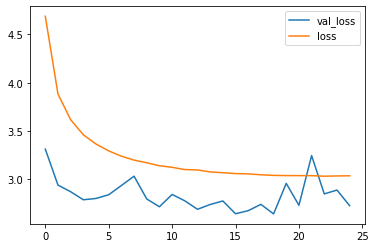

In [59]:
train_history.plot()

In [0]:
print('Minimum Loss\n',train_history.min()['val_loss'])
print('-----')
print('Minimum Loss on epoch: \n',train_history.idxmin()['val_loss']+1)

Minimum Loss
 2.6426074504852295
-----
Minimum Loss on epoch: 
 19


Looks like model at epoch 19 had performed best at dev set


# Evaluation

In [0]:
# Give a unique id to a word
def word_for_id(id, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == id:
            return word
    return None

# Generate a caption for an image
def generate_caption(model, tokenizer, image, max_length):
    input_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([input_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        # Predict next word
        pred_b = model.predict([image,sequence], verbose=0)
        pred = np.argmax(pred_b) # Remember it returns word Index
        # print(pred_b,'\t',pred)
        word = word_for_id(pred, tokenizer)
        # Stop if we cannot find the word
        if word is None:
            break
        # Generate next input_text
        input_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break

    return input_text

from nltk.translate.bleu_score import corpus_bleu
from tqdm import tqdm_notebook
def evaluate_model(model, test, tokenizer, max_len):
    actual, predicted = [], []
    # step over the whole set
    for img_id, img_feature, caption_list in tqdm_notebook(test):
        prediction = generate_caption(model, tokenizer, img_feature, max_len)
        ground_truth = [d.split() for d in caption_list[0]]
        actual.append(ground_truth)
        predicted.append(prediction.split())

    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))


In [0]:
from keras.models import load_model

# Load the best model
filename = 'model-ep019-loss3.041-val_loss2.643.h5'
model = load_model(filename)

# evaluate model
evaluate_model(model, test.values, tokenizer, max_len)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



BLEU-1: 0.515382
BLEU-2: 0.257140
BLEU-3: 0.170077
BLEU-4: 0.075534


# Checking Model

In [0]:
def extract_features_of_single_photo(filename,model):
    image = load_img(filename, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    return feature

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
def show_result(img_dir,image_fe_model):
    img_feature = extract_features_of_single_photo(img_dir,image_fe_model)
    caption = generate_caption(model, tokenizer, img_feature, max_len).split()
    caption=' '.join(caption[1:len(caption)-1])
    
    #Plot
    plt.axis('off')      
    img=mpimg.imread(img_dir)
    imgplot = plt.imshow(img)
    plt.title(caption)
    plt.show()    

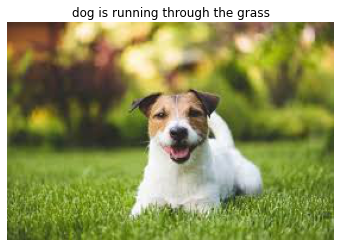

In [54]:
img_dir='/kaggle/input/images/Dog.jpg'
show_result(img_dir,image_fe_model)

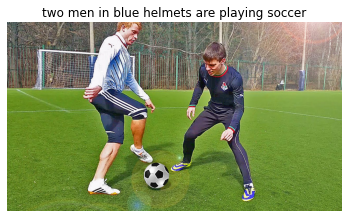

In [0]:
# Set the directory where your image belongs
img_dir='/kaggle/input/images/footballPlayer.jpg'
show_result(img_dir,image_fe_model)

# All the best